# Primena tehnika indeksiranja nad vektorskom bazom podataka Milvus

## Opis skupa podataka

Skup podataka koji je odabran za testiranje tehnika indeksiranja je [“News Category”](https://www.kaggle.com/datasets/rmisra/news-category-dataset) odnosno “Naslovi novinskih članaka” koji se sastoji od 210 hiljada uzoraka zapakovanih u jedan *.jsonl* fajl, tako da je svaki uzorak predstavljen kao jedan “json” objekat. Sva obeležja su tipa “string” čime želimo da naglasimo da na početku nije bilo vektorizovanih obeležja, pa je transformacija obeležja *short_description* rađena modelom mašinskog učenja.

Skup podataka sastoji se od 6 obeležja, a to su:
* *category* - kategorija kojoj novine pripadaju
* *headline* - naslov novina
* *authors* - kreator sadržaja novina
* *link* - URL adresa do novina
* *short_description* - kratak opis onoga o čemu se piše
* *date* - datum objavljivanja

## Primena modela vektorske ugradnje

* Obeležje *short_description* je odabrano za transformaciju u vektorsku ugradnju.
* Dimenzionalnost vektora je 384.
* Korišćen je model *all-MiniLM-L6-v2* modula SentenceTransformers.
* Dobijen je .json fajl vektorskih ugradnji veličine 1,8 GB.

## Parametri koji utiču na podešavanje indeksa
U razmatranje su uzeti parametri decimalne vektorske ugradnje.


**metric_type:**
* *L2* - Euklidsko rastojanje
* *COSINE* - Kosinusna sličnost
* *IP* - Skalarni proizvod

**index_type:**
* *FLAT* - upotreba bez indeksa
* *IVF_FLAT* - indeks baziran na kvantizaciji
* *IVF_SQ8* - indeks baziran na kvantizaciji
* *IVF_PQ* - indeks baziran na kvantizaciji
* *HNSW* - indeks baziran na upotrebi grafa
* *INVERTED* - invertovani indeks, primenljiv nad svim tipovima polja - indeks nevektorskih polja
* *STL_SORT* - podržava sva polja sem VARCHAR polja - indeks nevektorskih polja
* *Trie* - struktura tipa stablo, podržava VARCHAR polja - indeks nevektorskih polja



## 1. Pravljenje kolekcije

In [ ]:
from pymilvus import MilvusClient, DataType
from sentence_transformers import SentenceTransformer
import pandas as pd
from tqdm import tqdm
import time
import json

client = MilvusClient(
    uri = "http://localhost:19530"
)

DIMENSION = 384
COLLECTION_NAME = "news_collection"
MAX_ROWS = 210294
BATCH_SIZE = 128

news_json_file_path = 'News_Category_Dataset_v3.json'
embedding_json_file_path = 'news_short_description_embedding.json'

transformer = SentenceTransformer('all-MiniLM-L6-v2')

c:\Users\Vasilije\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Funkcija za ispis rezultata pretrage i brzine izvršavanja.

In [ ]:
def write_ouput(res, start, end):
    for hits_i, hits in enumerate(res):
        print('Headline:', search_terms[hits_i])
        print('Search Time:', end-start)
        print('Results:')
        for hit in hits:
            print( hit['entity'].get('headline'), '----', hit['distance'])
        print()

Funkcija za pretvaranje nestrukturiranog podatka u vektorsku ugradnju.

In [ ]:
def embed_search(data):
    embeds = transformer.encode(data)
    return [x for x in embeds]

Pravljenje šeme i priprema parametara indeksa.

In [ ]:
schema = MilvusClient.create_schema(
    auto_id = False,
    enable_dynamic_field = True,    # dynamic collection scheme
)

schema.add_field(field_name = "id", datatype=DataType.INT64, is_primary = True)
schema.add_field(field_name="headline", datatype=DataType.VARCHAR, max_length=400)
schema.add_field(field_name="embedding", datatype=DataType.FLOAT_VECTOR, dim=DIMENSION)
schema.add_field(field_name="link", datatype=DataType.VARCHAR, max_length=512)
schema.add_field(field_name="category", datatype=DataType.VARCHAR, max_length=200)
schema.add_field(field_name="short_description", datatype=DataType.VARCHAR, max_length=3000)
schema.add_field(field_name="authors", datatype=DataType.VARCHAR, max_length=512)
schema.add_field(field_name="date", datatype=DataType.VARCHAR, max_length=50)


index_params = client.prepare_index_params()

Slede različite kombinacije parametara prilikom kreiranja indeksa.

Indeksiranje skalara.

In [ ]:
index_params.add_index(
    index_name = "id_index",
    index_type = "STL_SORT",
    field_name = "id"
)

In [ ]:
index_params.add_index(
    index_name = "id_index",
    index_type = "INVERTED",
    field_name = "id"
)

In [ ]:
index_params.add_index(
    index_name = "category_index",
    field_name = "category",
    index_type = "Trie"
)

In [ ]:
index_params.add_index(
    index_name = "category_index",
    field_name = "category",
    index_type = "INVERTED"
)

Indeksiranje vektorskog atributa.

In [ ]:
index_params.add_index(
    index_name = "embedding_index",
    field_name = "embedding",
    index_type = "IVF_FLAT",
    metric_type = "L2",
    params = {"nlist": 1024}
)

In [ ]:
index_params.add_index(
    index_name = "embedding_index",
    field_name = "embedding",
    index_type = "FLAT",
    metric_type = "L2"
)

In [ ]:
index_params.add_index(
    index_name = "embedding_index",
    field_name = "embedding",
    index_type = "IVF_PQ",
    metric_type = "COSINE",
    params = {"nlist": 1024, "m": 128, "nbits": 8}
)

In [ ]:
index_params.add_index(
    index_name = "embedding_index",
    field_name = "embedding",
    index_type = "IVF_FLAT",
    metric_type = "L2",
    params = {"nlist": 1024, "m": 128, "nbits": 8}
)

In [ ]:
index_params.add_index(
    index_name = "embedding_index",
    field_name = "embedding",
    index_type = "HNSW",
    metric_type = "L2",
    params = {"M": 8, "efConstruction": 128}
)

In [ ]:
index_params.add_index(
    index_name = "embedding_index",
    field_name = "embedding",
    index_type = "IVF_SQ8",
    metric_type = "IP",
    params = {"nlist": 1024}
)

In [ ]:
index_params.add_index(
    index_name = "embedding_index",
    field_name = "embedding",
    index_type = "RHNSW_FLAT",
    metric_type = "L2",
    params = {"M": 8, "efConstruction": 128}
)

In [ ]:
index_params.add_index(
    index_name = "embedding_index",
    field_name = "embedding",
    index_type = "RHNSW_SQ",
    metric_type = "L2",
    params = {"M": 64, "efConstruction": 128}
)

In [ ]:
index_params.add_index(
    index_name = "embedding_index",
    field_name = "embedding",
    index_type = "SCANN",
    metric_type = "L2"
)

Naredba za brisanje kolekcije.

In [ ]:
client.drop_collection(
    collection_name=COLLECTION_NAME
)

Naredba za kreiranje kolekcije i učitavanje kolekcije.

In [ ]:
client.create_collection(
    collection_name = COLLECTION_NAME,
    schema = schema,
    index_params = index_params
)

client.load_collection(
    collection_name = "news_collection"
)

## 2. Pretvaranje i čuvanje vektorskih ugradnji *short_description-a*


Učitavanje vrednosti obeležja short_description svih slogova i pretvaranje u vektorske ugradnje. Slogovi su učitani iz .json fajla, pri čemu su i vektorske ugradnje sačuvane u formatu JSON.

In [ ]:
data = pd.read_json(news_json_file_path, lines=True)

data_batch = []

for index, row in tqdm(data.iterrows(), total=MAX_ROWS):
    short_description = row['short_description']

    data_batch.append(short_description)

    if index == MAX_ROWS:
        break

embeds = transformer.encode(data_batch)
embeddings = [x for x in embeds]
data = [ embeddings[i].tolist() for i in range(len(data_batch)) ]

with open(embedding_json_file_path, 'w') as f:
    json.dump(data, f)

100%|█████████▉| 209527/210294 [00:08<00:00, 24862.21it/s]


## 3. Insertovanje kolekcije

Učitavanje slogova i vektorskih ugradnji, kao i inicijalizacija liste listi.

In [ ]:
data = pd.read_json(news_json_file_path, lines=True)
short_description_embeddings = []
with open(embedding_json_file_path, 'r') as f:
    short_description_embeddings = json.load(f)

data_batch = [[], [], [], [], [], []]

Učitavanje batch-a slogova u kolekciju.

In [ ]:
def embed_insert(data, start_index):


    data = [ {
    "id": start_index + i,
    "headline": data[0][i],
    "embedding":  short_description_embeddings[start_index + i],
    "link": data[1][i],
    "category": data[2][i],
    "short_description": data[3][i],
    "authors": data[4][i],
    "date": data[5][i]
    } for i in range(len(data)) ]

    client.insert(
        collection_name=COLLECTION_NAME,
        data = data
    )

Prolazak kroz sve slogove i punjenje batch-a, pa pozivanje funkcije za unos u kolekciju.

In [ ]:
start_index = 0
for index, row in tqdm(data.iterrows(), total=MAX_ROWS):
    headline = row['headline']
    link = row['link']
    category = row['category']
    short_description = row['short_description']
    authors = row['authors']
    date = row['date'].strftime('%Y-%m-%d') if pd.notnull(row['date']) else None

    data_batch[0].append(headline)
    data_batch[1].append(link)
    data_batch[2].append(category)
    data_batch[3].append(short_description)
    data_batch[4].append(authors)
    data_batch[5].append(date)

    if len(data_batch[0]) % BATCH_SIZE == 0:
        embed_insert(data_batch, start_index)
        data_batch = [[], [], [], [], [], []]
        start_index = index + 1

    if index == MAX_ROWS:
        break

if len(data_batch[0]) != 0:
    embed_insert(data_batch, start_index)

100%|█████████▉| 209527/210294 [00:42<00:00, 4951.23it/s]


Osvežavanje kolekcije.

In [ ]:
# client.load_collection(collection_name=COLLECTION_NAME).flush()

client.refresh_load(collection_name=COLLECTION_NAME)

## 3. Izvršavanje različitih pretraga

### Upit br. 1

In [ ]:
search_terms = [
    'Novak Djokovic Serbian tennis player',
    'Joe Biden',
    'Trump'
]

query_vectors = embed_search(search_terms)
start = time.time()

res = client.search(
    collection_name = COLLECTION_NAME,
    data = query_vectors,
    anns_field= "embedding",
    limit = 1,
    output_fields=['id', 'category', 'headline']
)

end = time.time()

write_ouput(res, start, end)

print(json.dumps(res,indent=4))

Headline: Novak Djokovic Serbian tennis player
Search Time: 0.05854964256286621
Results:
Hilary Swank Engaged To Boyfriend Ruben Torres ---- 1.062304139137268

Headline: Joe Biden
Search Time: 0.05854964256286621
Results:
Obama Defends Auto Bailout: 'We Bet On American Workers' ---- 0.8880207538604736

Headline: Trump
Search Time: 0.05854964256286621
Results:
Recruitment Ad: Protect Our Nation And Trump's Feelings In The Coast Guard ---- 0.9412054419517517

[
    [
        {
            "id": 72066,
            "distance": 1.062304139137268,
            "entity": {
                "id": 72066,
                "category": "ENTERTAINMENT",
                "headline": "Hilary Swank Engaged To Boyfriend Ruben Torres"
            }
        }
    ],
    [
        {
            "id": 185472,
            "distance": 0.8880207538604736,
            "entity": {
                "id": 185472,
                "category": "BUSINESS",
                "headline": "Obama Defends Auto Bailout: 'We Bet O

Vremena izvršavanja upita u zavisnosti od različitih kombinacija odabranih indeksa.

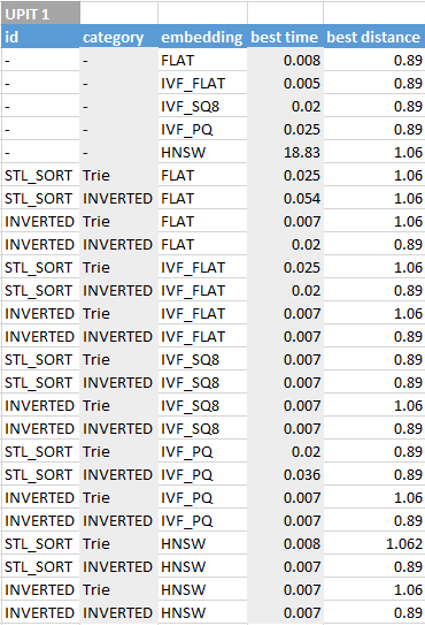

### Upit br. 2

In [ ]:
start = time.time()

res = client.search(
    collection_name = COLLECTION_NAME,
    data = query_vectors,
    filter = "10000 < id < 25000",
    limit = 1,
    output_fields=['headline', 'category']
)

end  = time.time()

write_ouput(res, start, end)

print(json.dumps(res,indent=4))

Headline: Novak Djokovic Serbian tennis player
Search Time: 0.031998395919799805
Results:
Alleged 'Nigerian Prince' Email Scammer Arrested In Louisiana ---- 1.4697197675704956

Headline: Joe Biden
Search Time: 0.031998395919799805
Results:
Donald Trump-Joe Biden Feud Sparks Savage Meme Ridiculing The Pair ---- 1.0830330848693848

Headline: Trump
Search Time: 0.031998395919799805
Results:
President Trump’s Iran Deal Message To North Korea: Do Not Trust Washington ---- 1.0937622785568237

[
    [
        {
            "id": 17281,
            "distance": 1.4697197675704956,
            "entity": {
                "headline": "Alleged 'Nigerian Prince' Email Scammer Arrested In Louisiana",
                "category": "CRIME"
            }
        }
    ],
    [
        {
            "id": 12162,
            "distance": 1.0830330848693848,
            "entity": {
                "headline": "Donald Trump-Joe Biden Feud Sparks Savage Meme Ridiculing The Pair",
                "category": "P

Vremena izvršavanja upita u zavisnosti od različitih kombinacija odabranih indeksa.

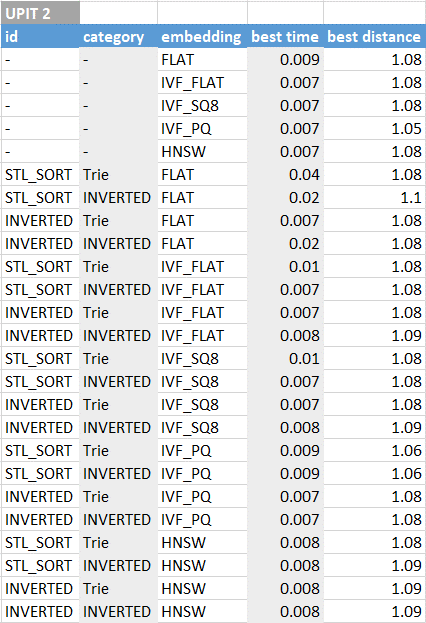

### Upit br. 3

In [ ]:
search_terms = [
    'Joe Biden'
]

query_vectors = embed_search(search_terms)

start = time.time()

res = client.search(
    collection_name = COLLECTION_NAME,
    data = query_vectors,
    filter = 'category == "POLITICS"',
    anns_field= "embedding",
    limit = 1,
    output_fields=['headline', 'category']
)

end  = time.time()

write_ouput(res, start, end)

print(json.dumps(res,indent=4))

Headline: Joe Biden
Search Time: 0.006987810134887695
Results:
GOP-Requested Witness Rejects Trump ‘Conspiracy Theories’ ---- 0.8970710039138794

[
    [
        {
            "id": 5760,
            "distance": 0.8970710039138794,
            "entity": {
                "headline": "GOP-Requested Witness Rejects Trump \u2018Conspiracy Theories\u2019",
                "category": "POLITICS"
            }
        }
    ]
]


Vremena izvršavanja upita u zavisnosti od različitih kombinacija odabranih indeksa.

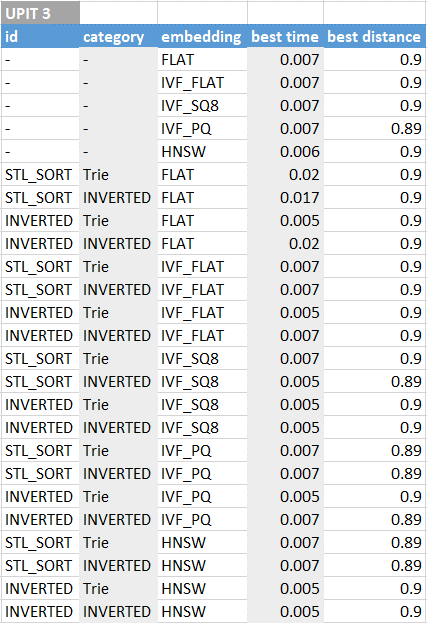

### Upit br. 4

In [ ]:
search_terms = [
    'Novak Djokovic'
]

query_vectors = embed_search(search_terms)

start = time.time()

res = client.search(
    collection_name = COLLECTION_NAME,
    data = query_vectors,
    filter = 'category not in  ["POLITICS", "BUSINESS", "COMEDY", "STYLE & BEAUTY"]',
    anns_field= "embedding",
    limit = 1,
    output_fields=['headline', 'category']
)
end  = time.time()

write_ouput(res, start, end)

print(json.dumps(res,indent=4))

Headline: Novak Djokovic
Search Time: 0.008985042572021484
Results:
Hilary Swank Engaged To Boyfriend Ruben Torres ---- 1.0996140241622925

[
    [
        {
            "id": 72066,
            "distance": 1.0996140241622925,
            "entity": {
                "headline": "Hilary Swank Engaged To Boyfriend Ruben Torres",
                "category": "ENTERTAINMENT"
            }
        }
    ]
]


Vremena izvršavanja upita u zavisnosti od različitih kombinacija odabranih indeksa.


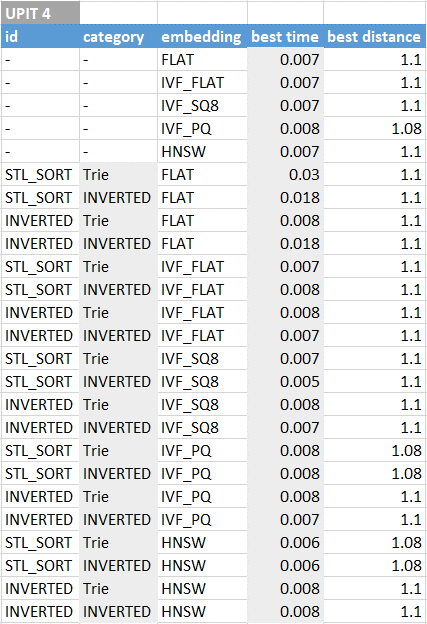

### Upit br. 5

In [ ]:
search_terms = [
    'US Military'
]

query_vectors = embed_search(search_terms)

start = time.time()

res = client.search(
    collection_name = COLLECTION_NAME,
    data = query_vectors,
    filter = 'headline like "%US%"',
    anns_field= "embedding",
    limit = 1,
    output_fields=['headline', 'link', 'category', 'date']
)

end  = time.time()

write_ouput(res, start, end)

print(json.dumps(res,indent=4))

Headline: US Military
Search Time: 0.01599431037902832
Results:
Doggone It, Our Own USA Olympic Team Doesn't Buy American? ---- 1.671411395072937

[
    [
        {
            "id": 193923,
            "distance": 1.671411395072937,
            "entity": {
                "category": "BUSINESS",
                "date": "2012-07-14",
                "headline": "Doggone It, Our Own USA Olympic Team Doesn't Buy American?",
                "link": "https://www.huffingtonpost.com/entry/doggone-it-our-own-usa-ol_us_5bb2c999e4b0480ca65c0e87"
            }
        }
    ]
]


Vremena izvršavanja upita u zavisnosti od različitih kombinacija odabranih indeksa.

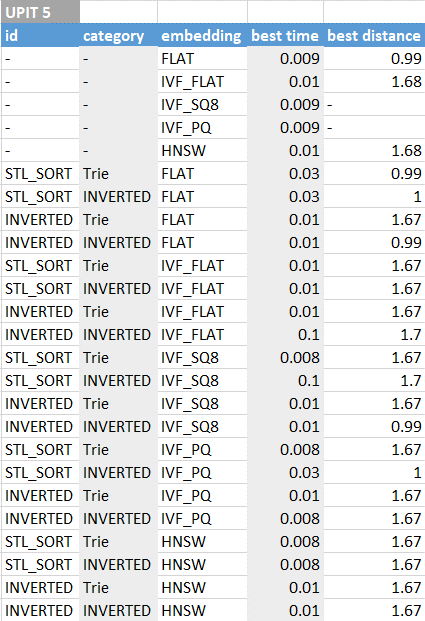

### Zaključak

200 000 uzoraka predstavlja relativno mali obim skupa podataka, stoga nisu uočene značajnije razlike pri optimizaciji performansi upotrebom indeksa.

## 4. Brisanje indeksa

Prikaz osnovne statistike nad kolekcijom.

In [ ]:
client.get_collection_stats(collection_name=COLLECTION_NAME)

{'row_count': 0}

Prikaz svih indeksa nad kolekcijom.

In [ ]:
client.list_indexes(COLLECTION_NAME)

['id_index', 'embedding_index']

Funkcija za brisanje indeksa.

In [ ]:
def index_deleting(index_name):
    client.release_collection(
        collection_name= COLLECTION_NAME
    )

    client.drop_index(
        collection_name = COLLECTION_NAME,
        index_name = index_name
    )

Funkcija za kreiranje indeksa.

In [ ]:
def index_creating(index_name, field_name, index_type, metric_type = None, params = None):
    index_params = client.prepare_index_params()

    if params == None:
        index_params.add_index(
            index_name = index_name,
            field_name = field_name,
            index_type = index_type,
            metric_type = metric_type
        )
    elif metric_type == None:
        index_params.add_index(
            index_name = index_name,
            field_name = field_name,
            index_type = index_type
        )
    elif params != None and metric_type != None:
        index_params.add_index(
            index_name = index_name,
            field_name = field_name,
            index_type = index_type,
            metric_type = metric_type,
            params = params
        )

    client.create_index(
        collection_name= COLLECTION_NAME,
        index_params=index_params
    )

Primeri naredbi za kreiranje i brisanje nekih od indeksa.

In [ ]:
index_creating("id_index", "id", "STL_SORT", None, None)

In [ ]:
index_creating("id_index", "id", "Trie", None, None)

In [ ]:
index_creating("category_index", "category", "INVERTED", None, None)

In [ ]:
index_creating("category_index", "category", "STL_SORT", None, None)

In [ ]:
index_creating("embedding_index", "embedding", "HNSW", "L2", {"M": 8, "efConstruction": 128})

In [ ]:
index_creating("embedding_index", "embedding", "IVF_SQ8", "L2", {"nlist": 1024})

In [ ]:
index_creating("embedding_index", "embedding", "IVF_PQ", "L2", {"nlist": 1024, "m": 128, "nbits": 8})

In [ ]:
index_creating("embedding_index", "embedding", "IVF_FLAT", "L2", {"nlist": 1024, "m": 128, "nbits": 8})

In [ ]:
index_creating("embedding_index", "embedding", "FLAT", "L2")

In [ ]:
index_deleting('category_index')

**Napomena:** Ćelije se ne izvršavaju isključivo sekvencijalno.